# Convergence curve of the TuRBO algorithm by batch size on Schwefel Function

## 1. Imports

In [1]:
from turbo import TurboM 
import numpy as np
import pandas as pd
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import csv
import time
import ast

## 2. Function as a Class

In [3]:
class Schwefel:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -500 * np.ones(dim)
        self.ub = 500 * np.ones(dim)

    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        val = np.sum(x * np.sin(np.sqrt(np.abs(x))))
        return 418.9829 * self.dim - val
    
f = Schwefel(10)

## 3. Desired configurations for the experiment

In [4]:
n_times = 5

In [5]:
max_evals_desired = 500

## 4. Experiment

In [6]:
batch_size_list = [1, 5, 10, 20, 30, 40, 50]

with open("execution_times.csv", "w", newline="") as time_file:
    time_writer = csv.writer(time_file)
    time_writer.writerow(["batch_size", "t", "time_seconds"])


    for BS in batch_size_list:

        filename = f"turbo_results_BS_{BS}.csv"

        with open(filename, "w", newline="") as result_file:

            result_writer = csv.writer(result_file)

            result_writer.writerow(["best_value", "best_x", "batch_size", "t"])

            for t in range(n_times):

                np.random.seed(t)
                torch.manual_seed(t)

                turbo_m = TurboM(
                    f=f,
                    lb=f.lb,
                    ub=f.ub,
                    n_init=10,
                    max_evals=max_evals_desired,
                    n_trust_regions=5,
                    batch_size=BS,
                    verbose=False,
                    use_ard=True,
                    max_cholesky_size=2000,
                    n_training_steps=50,
                    min_cuda=1024,
                    device="cpu",
                    dtype="float64",
                )

                start_time = time.time()
                turbo_m.optimize()
                end_time = time.time()

                elapsed_time = end_time - start_time

                time_writer.writerow([BS, t, elapsed_time])

                X = turbo_m.X
                fX = turbo_m.fX

                best_so_far = np.inf
                best_x_so_far = None

                for i in range(len(fX)):

                    if fX[i] < best_so_far:
                        best_so_far = fX[i]
                        best_x_so_far = X[i]

                    result_writer.writerow([
                        best_so_far,
                        list(best_x_so_far),
                        BS,
                        t
                    ])

## 5. Plotting the convergence curve

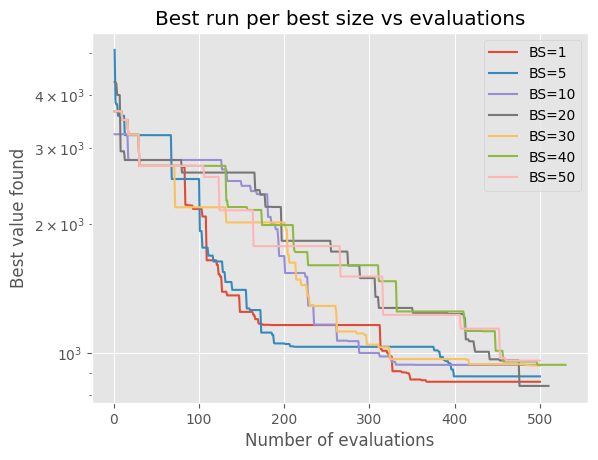

In [5]:
plt.style.use("ggplot")

plt.figure()

for BS in batch_size_list:

    filename = f"turbo_results_BS_{BS}.csv"
    df = pd.read_csv(filename)

    best_per_t = df.groupby("t")["best_value"].min()
    best_t = best_per_t.idxmin()

    df_best = df[df["t"] == best_t]

    evaluations = range(1, len(df_best) + 1)

    df_best["best_value"] = (df_best["best_value"].str.strip("[]").astype(float))

    plt.plot(evaluations, df_best["best_value"], label = f"BS={BS}")

plt.xlabel("Number of evaluations")
plt.ylabel("Best value found")
plt.title("Best run per best size vs evaluations")

# In portuguese
# plt.xlabel("Número de avaliações")
# plt.ylabel("Melhor valor encontrado (log)")
# plt.title("Função Schwefel \n\nMelhor valor encontrado por avaliação")

plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
    

## 6. Plotting the time needed for each batch size simulation

This gets the values of the time needed for each batch size for each experiment (`n_times`) and plots the mean

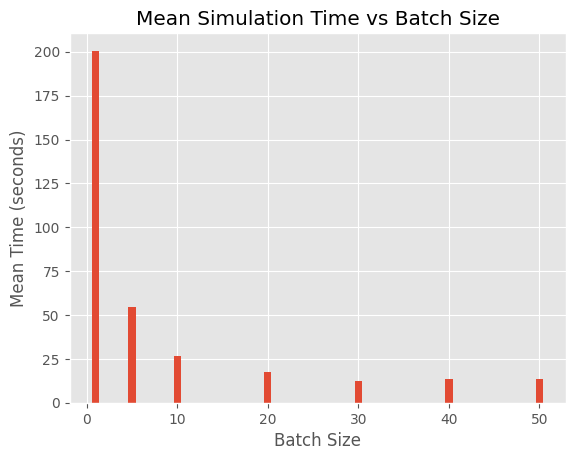

In [6]:
df_time = pd.read_csv("execution_times.csv")

mean_times = df_time.groupby("batch_size")["time_seconds"].mean()

plt.figure()
plt.bar(mean_times.index, mean_times.values)

plt.xlabel("Batch Size")
plt.ylabel("Mean Time (seconds)")
plt.title("Mean Simulation Time vs Batch Size")

# In portuguese
# plt.xlabel("Batch Size")
# plt.ylabel("Tempo médio (s)")
# plt.title("Função Schwefel \n\nTempo médio por batch size")

plt.grid(True)
plt.show()

## 7. Plotting the distance between the best point found and the minimum (Euclidian distance) over evaluations

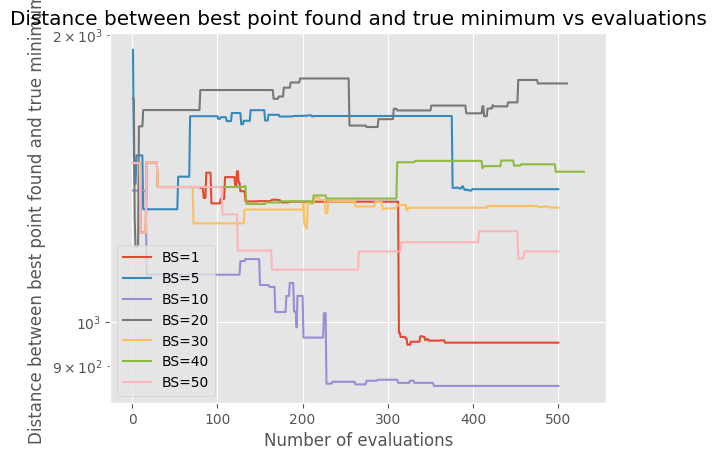

In [7]:
minimum = [420.9687] * 10

minimum = np.array(minimum)

plt.figure()

for BS in batch_size_list:

    filename = f"turbo_results_BS_{BS}.csv"
    df = pd.read_csv(filename)

    best_per_t = df.groupby("t")["best_value"].min()
    best_t = best_per_t.idxmin()

    df_best = df[df["t"] == best_t]

    df_best["best_x"] = (
    df_best["best_x"]
    .str.replace("np.float64(", "", regex=False)
    .str.replace(")", "", regex=False)
    .apply(ast.literal_eval)
)

    evaluations = range(1, len(df_best) + 1)

    X = np.array(df_best["best_x"].tolist())

    dist = np.linalg.norm(X - minimum, axis=1)

    plt.plot(evaluations, dist, label = f"BS={BS}")

plt.xlabel("Number of evaluations")
plt.ylabel("Distance between best point found and true minimum")
plt.title("Distance between best point found and true minimum vs evaluations")
plt.yscale("log")

# In portuguese
# plt.xlabel("Número de avaliações")
# plt.ylabel("Distância do melhor ponto ao mínimo global (log)")
# plt.title("Função Schwefel \n\nDistância do melhor ponto ao mínimo global por avaliação")


plt.grid(True)
plt.legend()
plt.show()